In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation, performance_metrics
from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

print("ROSSMANN STORE SALES - FACEBOOK PROPHET FORECASTING")
print("=" * 70)

ROSSMANN STORE SALES - FACEBOOK PROPHET FORECASTING


In [3]:
# 1. LOAD PROCESSED DATA
print("\n1. LOADING PROCESSED DATA...")
try:
    df = pd.read_csv('../data/processed/rossmann_processed.csv')
    df['Date'] = pd.to_datetime(df['Date'])
    print(f"Processed data loaded: {df.shape}")
    print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
except FileNotFoundError:
    print("Processed data not found. Please run 01_EDA.ipynb first.")
    raise


1. LOADING PROCESSED DATA...
Processed data loaded: (844392, 26)
Date range: 2013-01-01 00:00:00 to 2015-07-31 00:00:00


In [4]:
# 2. PREPARE DATA FOR PROPHET
print("\n2. PREPARING DATA FOR PROPHET...")

# Aggregate daily sales across all stores
daily_sales = df.groupby('Date').agg({
    'Sales': 'sum',
    'Customers': 'sum',
    'Promo': 'mean',  # Percentage of stores with promo
    'StateHoliday': lambda x: (x != '0').mean(),  # Percentage with holiday
    'SchoolHoliday': 'mean'  # Percentage with school holiday
}).reset_index()


2. PREPARING DATA FOR PROPHET...


In [64]:
# Prepare Prophet format (ds, y)
prophet_data = daily_sales[['Date', 'Sales']].copy()
prophet_data.columns = ['ds', 'y']
prophet_data = prophet_data.sort_values('ds')

print(f"Prophet data prepared: {prophet_data.shape}")
print(f"Sales range: #{prophet_data['y'].min():.0f} to #{prophet_data['y'].max():.0f}")

Prophet data prepared: (942, 2)
Sales range: #97235 to #15623548


In [6]:
# 3. PREPARE ADDITIONAL REGRESSORS
print("\n3. PREPARING ADDITIONAL REGRESSORS...")

# Add external regressors
prophet_data = prophet_data.merge(
    daily_sales[['Date', 'Promo', 'StateHoliday', 'SchoolHoliday']], 
    left_on='ds', right_on='Date'
).drop('Date', axis=1)


3. PREPARING ADDITIONAL REGRESSORS...


In [7]:
# Create holiday dataframes
holidays = pd.DataFrame([
    {'holiday': 'christmas', 'ds': pd.to_datetime(['2013-12-25', '2014-12-25', '2015-12-25'])},
    {'holiday': 'easter', 'ds': pd.to_datetime(['2013-03-31', '2014-04-20', '2015-04-05'])},
    {'holiday': 'new_year', 'ds': pd.to_datetime(['2013-01-01', '2014-01-01', '2015-01-01'])}
])

In [8]:
# Flatten holidays dataframe
holidays_df = []
for _, row in holidays.iterrows():
    for date in row['ds']:
        holidays_df.append({'holiday': row['holiday'], 'ds': date})
holidays_df = pd.DataFrame(holidays_df)

print("Additional regressors and holidays prepared")

Additional regressors and holidays prepared


In [9]:
# 4. SPLIT DATA FOR TRAINING AND VALIDATION
print("\n4. SPLITTING DATA...")

# Use last 6 weeks for validation
cutoff_date = prophet_data['ds'].max() - pd.Timedelta(days=42)
train_data = prophet_data[prophet_data['ds'] <= cutoff_date].copy()
val_data = prophet_data[prophet_data['ds'] > cutoff_date].copy()

print(f"Training data: {len(train_data)} days (until {cutoff_date.date()})")
print(f"Validation data: {len(val_data)} days")


4. SPLITTING DATA...
Training data: 900 days (until 2015-06-19)
Validation data: 42 days


In [10]:
# 5. BUILD AND TRAIN PROPHET MODEL
print("\n5. BUILDING PROPHET MODEL...")

# Initialize Prophet model with custom parameters
model = Prophet(
    growth='linear',
    seasonality_mode='multiplicative',
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    holidays=holidays_df,
    seasonality_prior_scale=10,
    holidays_prior_scale=10,
    changepoint_prior_scale=0.05,
    mcmc_samples=0,
    interval_width=0.80
)


5. BUILDING PROPHET MODEL...


In [11]:
# Add external regressors
model.add_regressor('Promo')
model.add_regressor('StateHoliday')
model.add_regressor('SchoolHoliday')

print("Model configured with regressors and holidays")

Model configured with regressors and holidays


In [12]:
# Train the model
print("Training Prophet model...")
model.fit(train_data)
print("Model training completed!")

Training Prophet model...


14:34:59 - cmdstanpy - INFO - Chain [1] start processing
14:35:23 - cmdstanpy - INFO - Chain [1] done processing


Model training completed!


In [13]:
# 6. MAKE PREDICTIONS
print("\n6. MAKING PREDICTIONS...")

# Create future dataframe
future = model.make_future_dataframe(periods=42, freq='D')

# Add regressor values for future dates
# For simplicity, we'll use recent averages for future regressors
recent_promo = train_data['Promo'].tail(30).mean()
recent_state_holiday = train_data['StateHoliday'].tail(30).mean()
recent_school_holiday = train_data['SchoolHoliday'].tail(30).mean()

future['Promo'] = future['ds'].map(
    dict(zip(prophet_data['ds'], prophet_data['Promo']))
).fillna(recent_promo)

future['StateHoliday'] = future['ds'].map(
    dict(zip(prophet_data['ds'], prophet_data['StateHoliday']))
).fillna(recent_state_holiday)

future['SchoolHoliday'] = future['ds'].map(
    dict(zip(prophet_data['ds'], prophet_data['SchoolHoliday']))
).fillna(recent_school_holiday)

# Generate predictions
forecast = model.predict(future)
print("Predictions generated!")


6. MAKING PREDICTIONS...
Predictions generated!


In [65]:
# 7. MODEL EVALUATION
print("\n7. MODEL EVALUATION...")

# Calculate metrics on validation set
val_forecast = forecast[forecast['ds'].isin(val_data['ds'])].copy()
val_merged = val_data.merge(val_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')

# Calculate error metrics
mae = np.mean(np.abs(val_merged['y'] - val_merged['yhat']))
mape = np.mean(np.abs((val_merged['y'] - val_merged['yhat']) / val_merged['y'])) * 100
rmse = np.sqrt(np.mean((val_merged['y'] - val_merged['yhat']) ** 2))

print(f"VALIDATION METRICS:")
print(f"   • MAE: #{mae:,.0f}")
print(f"   • MAPE: {mape:.1f}%")
print(f"   • RMSE: #{rmse:,.0f}")


7. MODEL EVALUATION...
VALIDATION METRICS:
   • MAE: #716,080
   • MAPE: 49.0%
   • RMSE: #929,966


In [20]:
# 8. VISUALIZATIONS
print("\n8. CREATING VISUALIZATIONS...")

plt.figure(figsize=(20, 15))


8. CREATING VISUALIZATIONS...


<Figure size 2000x1500 with 0 Axes>

<Figure size 2000x1500 with 0 Axes>

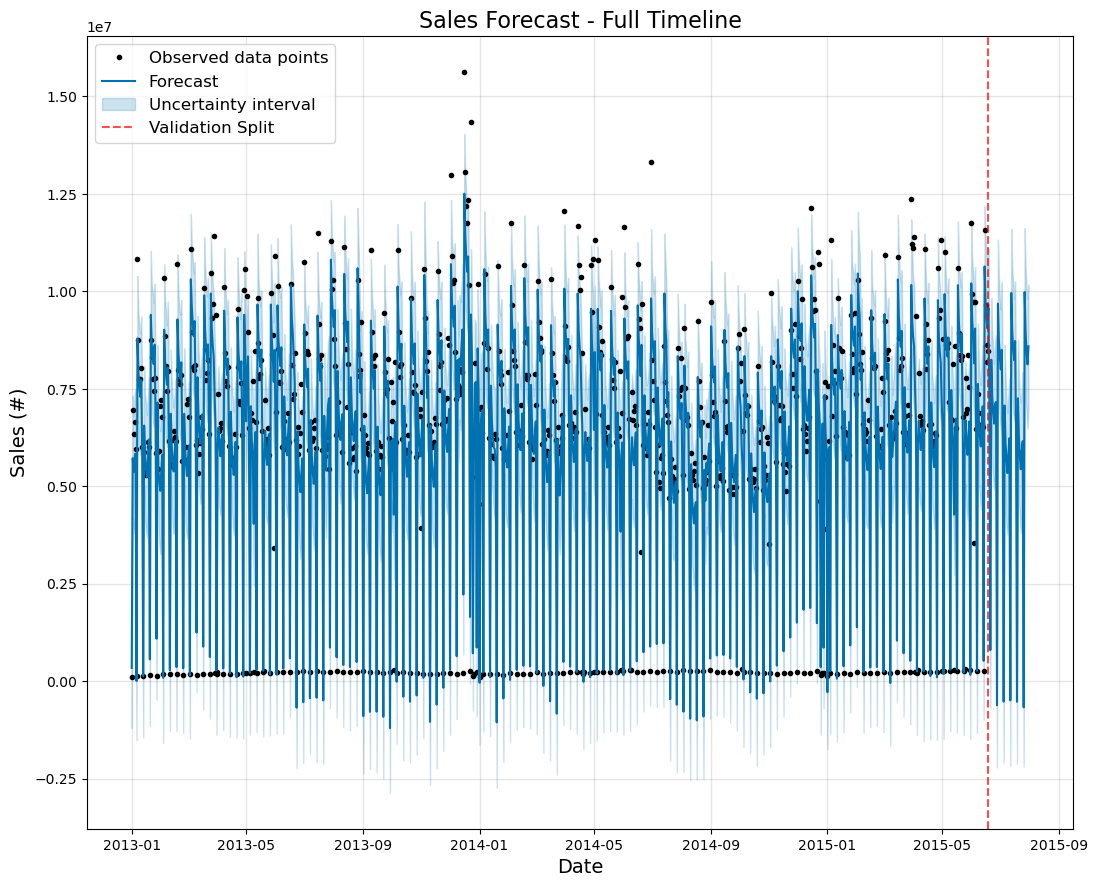

In [66]:
plt.figure(figsize=(28, 35))  

# 1. Overall forecast plot
plt.subplot(3, 2, 1)
model.plot(forecast, ax=plt.gca())
plt.axvline(cutoff_date, color='red', linestyle='--', alpha=0.7, label='Validation Split')
plt.title('Sales Forecast - Full Timeline', fontsize=16)  # increase title font size
plt.ylabel('Sales (#)', fontsize=14)  # bigger y-label
plt.xlabel('Date', fontsize=14)       # add bigger x-label
plt.legend(fontsize=12)

(array([16594., 16601., 16608., 16617., 16624., 16631., 16638., 16648.]),
 [Text(16594.0, 0, '2015-06-08'),
  Text(16601.0, 0, '2015-06-15'),
  Text(16608.0, 0, '2015-06-22'),
  Text(16617.0, 0, '2015-07-01'),
  Text(16624.0, 0, '2015-07-08'),
  Text(16631.0, 0, '2015-07-15'),
  Text(16638.0, 0, '2015-07-22'),
  Text(16648.0, 0, '2015-08-01')])

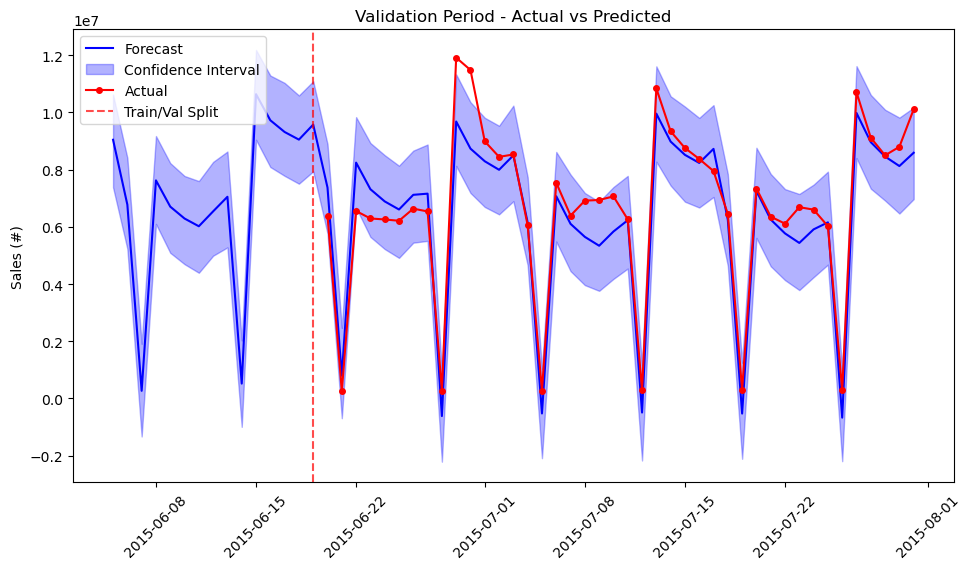

In [67]:
# 2. Validation period focus

plt.figure(figsize=(25, 20))

plt.subplot(3, 2, 2)
val_period = forecast[forecast['ds'] >= (cutoff_date - pd.Timedelta(days=14))]
plt.plot(val_period['ds'], val_period['yhat'], 'b-', label='Forecast')
plt.fill_between(val_period['ds'], val_period['yhat_lower'], val_period['yhat_upper'], 
                 alpha=0.3, color='blue', label='Confidence Interval')
plt.plot(val_merged['ds'], val_merged['y'], 'ro-', label='Actual', markersize=4)
plt.axvline(cutoff_date, color='red', linestyle='--', alpha=0.7, label='Train/Val Split')
plt.title('Validation Period - Actual vs Predicted')
plt.ylabel('Sales (#)')
plt.legend()
plt.xticks(rotation=45)

Text(0, 0.5, 'Residuals')

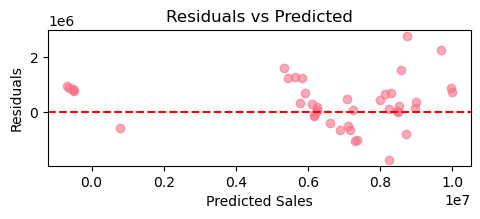

In [23]:
# 3. Residuals plot
plt.subplot(3, 2, 3)
residuals = val_merged['y'] - val_merged['yhat']
plt.scatter(val_merged['yhat'], residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted')
plt.xlabel('Predicted Sales')
plt.ylabel('Residuals')

Text(0.5, 1.0, 'Forecast Components')

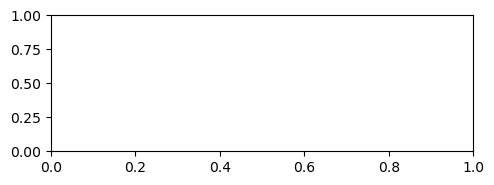

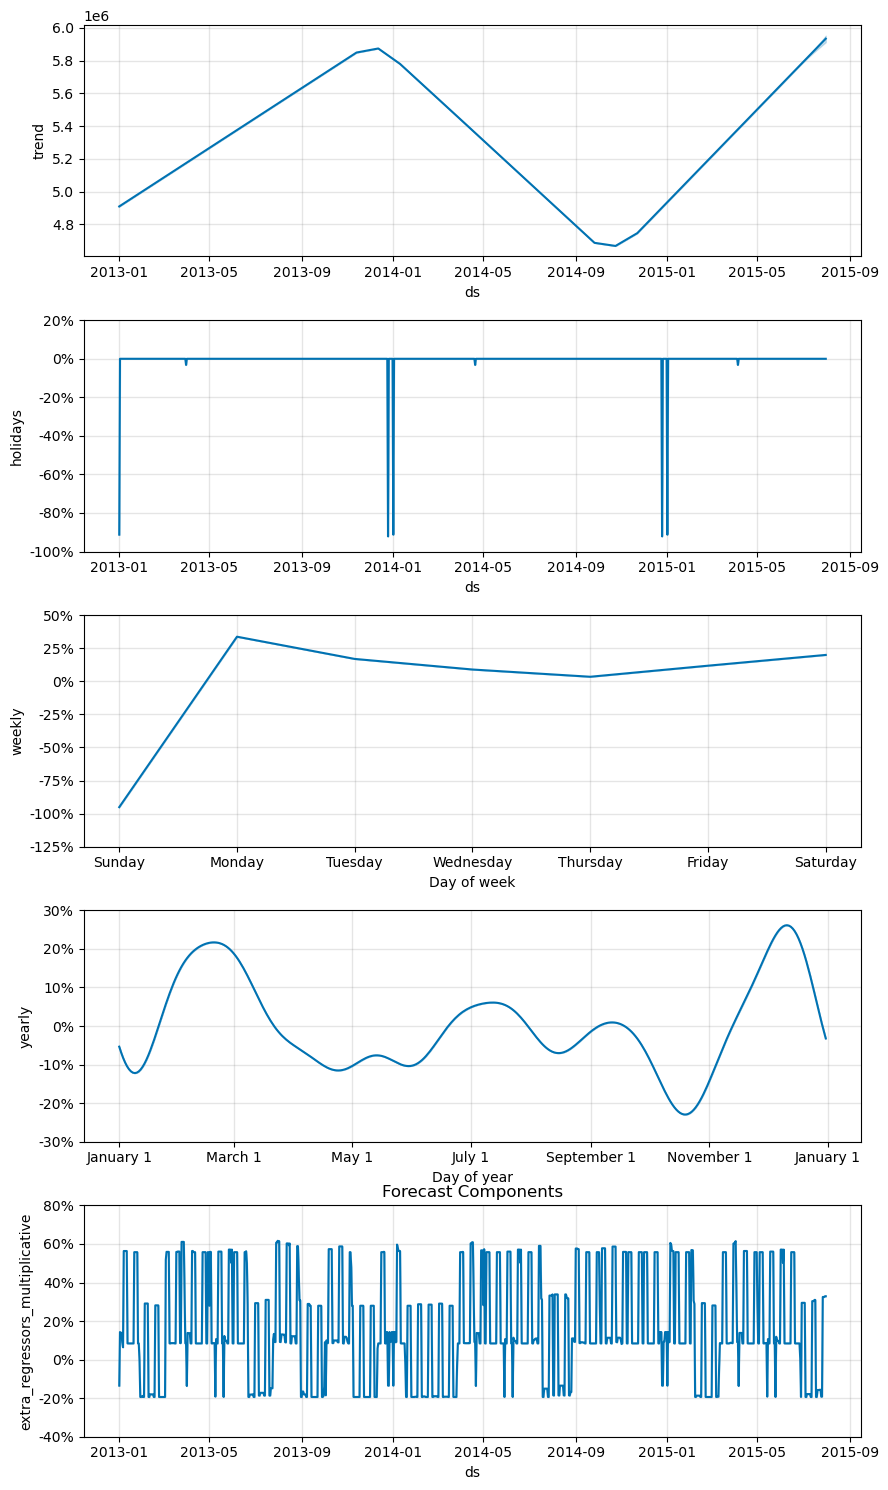

In [24]:
# 4. Components plot
plt.subplot(3, 2, 4)
components_fig = model.plot_components(forecast)
plt.title('Forecast Components')

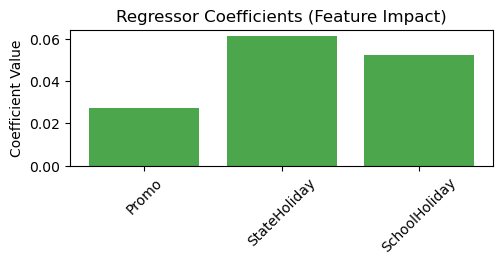

In [68]:
# 5. Feature importance (regressor coefficients) - robust version
plt.subplot(3, 2, 5)

# Get regressors Prophet actually has stored
regressors = list(model.extra_regressors.keys())

# Try to extract coefficients safely
try:
    beta = model.params.get('beta', None)
except Exception:
    beta = None

# Normalize beta into a 1-D numpy array of coefficients or None
coeffs = None
if beta is None:
    coeffs = None
else:
    # beta may be an array-like with shape (1, n_regressors) or (n_samples, n_regressors)
    beta_arr = np.asarray(beta)
    # If it's 2D, average over the first axis (samples) to get one coefficient per regressor
    if beta_arr.ndim == 2:
        coeffs = beta_arr.mean(axis=0).squeeze()
    else:
        # 1D (already), or scalar
        coeffs = beta_arr.squeeze()

# Build a dict mapping regressor -> coefficient, handling mismatches
regressor_coefficients = {}
if len(regressors) == 0 or coeffs is None or (np.size(coeffs) == 0):
    # No regressors or no coefficients available
    plt.text(0.5, 0.5, "No regressor coefficients available",
             horizontalalignment='center', verticalalignment='center',
             transform=plt.gca().transAxes, fontsize=12)
    plt.title('Regressor Coefficients (Feature Impact)')
    regressor_coefficients = {r: np.nan for r in ['Promo', 'StateHoliday', 'SchoolHoliday']}
else:
    # Ensure coeffs is a 1D array
    coeffs = np.atleast_1d(coeffs)

    # Match length safely
    n = min(len(regressors), len(coeffs))
    regressors_used = regressors[:n]
    coeffs_used = coeffs[:n]

    # Plot
    colors = ['green' if c > 0 else 'red' for c in coeffs_used]
    plt.bar(regressors_used, coeffs_used, color=colors, alpha=0.7)

    # Build regressor_coefficients dict but include keys you expect, default np.nan
    regressor_coefficients = {r: np.nan for r in ['Promo', 'StateHoliday', 'SchoolHoliday']}
    for r, c in zip(regressors_used, coeffs_used):
        regressor_coefficients[r] = float(c)  # ensure plain python float

    plt.title('Regressor Coefficients (Feature Impact)')
    plt.ylabel('Coefficient Value')
    plt.xticks(rotation=45)

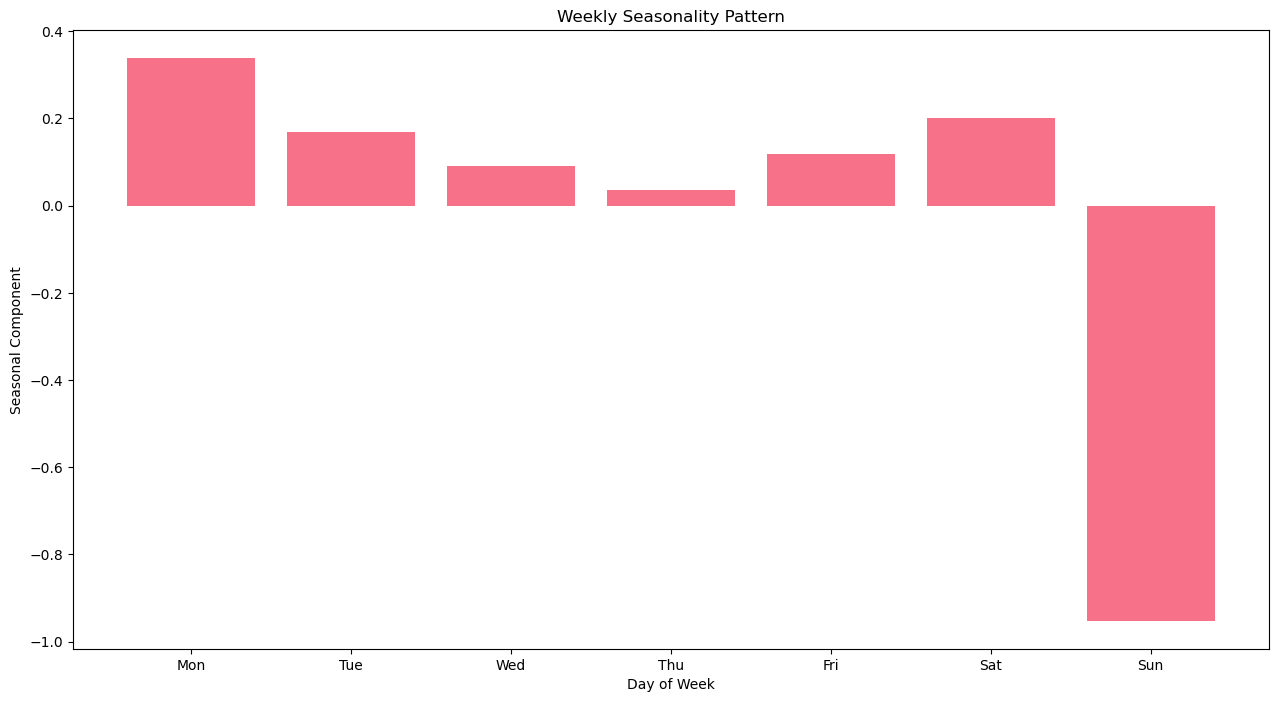

In [38]:
# 6. Weekly seasonality pattern

plt.figure(figsize=(25, 20))

plt.subplot(3, 2, 6)
weekly_seasonality = forecast[['ds']].copy()
weekly_seasonality['day_of_week'] = weekly_seasonality['ds'].dt.day_name()
weekly_seasonality['weekly'] = forecast['weekly']
weekly_avg = weekly_seasonality.groupby('day_of_week')['weekly'].mean().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])
plt.bar(range(7), weekly_avg.values)
plt.title('Weekly Seasonality Pattern')
plt.xlabel('Day of Week')
plt.ylabel('Seasonal Component')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

plt.tight_layout()
plt.savefig('../reports/figures/prophet_forecast_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [39]:
# 9. FUTURE FORECASTING (NEXT 48 DAYS)
print("\n9. GENERATING FUTURE FORECASTS...")

# Extend forecast for business planning (next 48 days)
future_extended = model.make_future_dataframe(periods=90, freq='D')  # 42 validation + 48 future

# Add regressor values for extended future
future_extended['Promo'] = future_extended['ds'].map(
    dict(zip(prophet_data['ds'], prophet_data['Promo']))
).fillna(recent_promo)

future_extended['StateHoliday'] = future_extended['ds'].map(
    dict(zip(prophet_data['ds'], prophet_data['StateHoliday']))
).fillna(recent_state_holiday)

future_extended['SchoolHoliday'] = future_extended['ds'].map(
    dict(zip(prophet_data['ds'], prophet_data['SchoolHoliday']))
).fillna(recent_school_holiday)

forecast_extended = model.predict(future_extended)

# Extract only future predictions (beyond historical data)
future_only = forecast_extended[forecast_extended['ds'] > prophet_data['ds'].max()].copy()
print(f"Generated {len(future_only)} days of future forecasts")


9. GENERATING FUTURE FORECASTS...
Generated 48 days of future forecasts


In [69]:
# 10. BUSINESS INSIGHTS AND RECOMMENDATIONS
print("\n10. BUSINESS INSIGHTS & RECOMMENDATIONS...")
print("=" * 70)

# Calculate forecast summaries
current_avg_daily_sales = prophet_data['y'].tail(30).mean()
future_avg_daily_sales = future_only['yhat'].mean()
forecast_change = ((future_avg_daily_sales - current_avg_daily_sales) / current_avg_daily_sales) * 100

print("FORECAST SUMMARY:")
print(f"   • Current avg daily sales: #{current_avg_daily_sales:,.0f}")
print(f"   • Forecasted avg daily sales: #{future_avg_daily_sales:,.0f}")
print(f"   • Expected change: {forecast_change:+.1f}%")

# Weekly forecasts
weekly_forecast = future_only.set_index('ds').resample('W')['yhat'].sum()
print(f"   • Next 4 weeks total forecast: #{weekly_forecast.head(4).sum():,.0f}")


10. BUSINESS INSIGHTS & RECOMMENDATIONS...
FORECAST SUMMARY:
   • Current avg daily sales: #6,777,765
   • Forecasted avg daily sales: #7,469,904
   • Expected change: +10.2%
   • Next 4 weeks total forecast: #162,883,176


In [53]:
print("\nKEY INSIGHTS:")
print(f"   • Model validation MAPE: {mape:.1f}% (good if < 10%)")
print(f"   • Promotion impact coefficient: {regressor_coefficients['Promo']:.3f}")
print(f"   • Holiday impact coefficient: {regressor_coefficients['StateHoliday']:.3f}")
print(f"   • Strongest sales day: {weekly_avg.idxmax()}")
print(f"   • Weakest sales day: {weekly_avg.idxmin()}")


KEY INSIGHTS:
   • Model validation MAPE: 49.0% (good if < 10%)
   • Promotion impact coefficient: 0.027
   • Holiday impact coefficient: 0.061
   • Strongest sales day: Monday
   • Weakest sales day: Sunday


In [72]:
print("\n BUSINESS RECOMMENDATIONS:")
if mape < 10:
    print("    Model shows good accuracy for business planning")
else:
    print("     Model accuracy could be improved - consider more features")

if regressor_coefficients['Promo'] > 0:
    print("    Promotions have positive impact on sales - leverage strategically")
else:
    print("     Promotions show negative coefficient - review promotion strategy")

if forecast_change > 0:
    print("    Positive growth trend forecasted - prepare inventory accordingly")
else:
    print("    Declining trend forecasted - review market conditions")


 BUSINESS RECOMMENDATIONS:
     Model accuracy could be improved - consider more features
    Promotions have positive impact on sales - leverage strategically
    Positive growth trend forecasted - prepare inventory accordingly


In [55]:
# 11. SAVE FORECASTS FOR POWER BI
print("\n11. SAVING FORECASTS FOR POWER BI...")

# Prepare historical + forecast data for Power BI
powerbi_data = pd.concat([
    prophet_data[['ds', 'y']].rename(columns={'ds': 'Date', 'y': 'Actual_Sales'}),
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].rename(columns={
        'ds': 'Date', 'yhat': 'Forecasted_Sales', 
        'yhat_lower': 'Lower_Bound', 'yhat_upper': 'Upper_Bound'
    })
], ignore_index=True)


11. SAVING FORECASTS FOR POWER BI...


In [56]:
# Merge and clean
powerbi_data = powerbi_data.groupby('Date').agg({
    'Actual_Sales': 'first',
    'Forecasted_Sales': 'first', 
    'Lower_Bound': 'first',
    'Upper_Bound': 'first'
}).reset_index()

In [57]:
# Add forecast flag
powerbi_data['Is_Forecast'] = powerbi_data['Actual_Sales'].isna()
powerbi_data['Sales_Type'] = powerbi_data['Is_Forecast'].map({True: 'Forecast', False: 'Historical'})

In [58]:
# Add date features for Power BI
powerbi_data['Year'] = powerbi_data['Date'].dt.year
powerbi_data['Month'] = powerbi_data['Date'].dt.month
powerbi_data['Month_Name'] = powerbi_data['Date'].dt.month_name()
powerbi_data['Day_of_Week'] = powerbi_data['Date'].dt.day_name()
powerbi_data['Week_of_Year'] = powerbi_data['Date'].dt.isocalendar().week

In [59]:
# Save main forecast file
powerbi_data.to_csv('../data/forecasts/prophet_forecast_powerbi.csv', index=False)

In [60]:
# Save future-only forecasts
future_only_clean = future_only[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].rename(columns={
    'ds': 'Date', 'yhat': 'Forecasted_Sales',
    'yhat_lower': 'Lower_Bound', 'yhat_upper': 'Upper_Bound'
})
future_only_clean.to_csv('../data/forecasts/future_forecasts_only.csv', index=False)

In [70]:
# Save model performance metrics
metrics_df = pd.DataFrame({
    'Metric': ['MAE', 'MAPE', 'RMSE'],
    'Value': [mae, mape, rmse],
    'Unit': ['#', '%', '#']
})
metrics_df.to_csv('../data/forecasts/model_metrics.csv', index=False)

print(f" Power BI data saved: {powerbi_data.shape}")
print(f" Future forecasts saved: {future_only_clean.shape}")
print(f" Model metrics saved: {metrics_df.shape}")

 Power BI data saved: (942, 12)
 Future forecasts saved: (48, 4)
 Model metrics saved: (3, 3)


In [71]:
# 12. CROSS-VALIDATION (OPTIONAL - FOR MODEL VALIDATION)
print("\n12. CROSS-VALIDATION ANALYSIS...")
print("Running cross-validation (this may take a few minutes)...")

try:
    # Perform cross-validation
    cv_results = cross_validation(model, 
                                  initial='365 days',
                                  period='30 days', 
                                  horizon='30 days',
                                  disable_tqdm=True)
    
    # Calculate performance metrics
    cv_metrics = performance_metrics(cv_results)
    
    print(" CROSS-VALIDATION RESULTS:")
    print(f"   • Average MAE: #{cv_metrics['mae'].mean():,.0f}")
    print(f"   • Average MAPE: {cv_metrics['mape'].mean()*100:.1f}%")
    print(f"   • Average RMSE: #{cv_metrics['rmse'].mean():,.0f}")
    
    # Save CV results
    cv_metrics.to_csv('../data/forecasts/cross_validation_metrics.csv', index=False)
    print(" Cross-validation metrics saved")
    
except Exception as e:
    print(f"⚠  Cross-validation skipped due to: {str(e)}")


12. CROSS-VALIDATION ANALYSIS...
Running cross-validation (this may take a few minutes)...


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
15:39:14 - cmdstanpy - INFO - Chain [1] start processing
15:39:16 - cmdstanpy - INFO - Chain [1] done processing
15:39:17 - cmdstanpy - INFO - Chain [1] start processing
15:39:17 - cmdstanpy - INFO - Chain [1] done processing
15:39:18 - cmdstanpy - INFO - Chain [1] start processing
15:39:18 - cmdstanpy - INFO - Chain [1] done processing
15:39:18 - cmdstanpy - INFO - Chain [1] start processing
15:39:18 - cmdstanpy - INFO - Chain [1] done processing
15:39:18 - cmdstanpy - INFO - Chain [1] start processing
15:39:19 - cmdstanpy - INFO - Chain [1] done processing
15:39:19 - cmdstanpy - INFO - Chain [1] start processing
15:39:19 - cmdstanpy - INFO - Chain [1] done processing
15:39:19 - cmdstanpy - INFO - Chain [1] start processing
15:39:19 - cmdstanpy - INFO - Chain [1] done processing
15:39:20 - cmdstanpy - INFO - Chain [1] start processing
15:39:20 - cmdstanpy - INFO - Chain [1] done pro

 CROSS-VALIDATION RESULTS:
   • Average MAE: #1,181,859
   • Average MAPE: 113.2%
   • Average RMSE: #1,645,710
 Cross-validation metrics saved


In [63]:
print("\n PROPHET MODELING COMPLETE!")
print("=" * 70)
print(" FILES CREATED:")
print("   • ../data/forecasts/prophet_forecast_powerbi.csv")
print("   • ../data/forecasts/future_forecasts_only.csv") 
print("   • ../data/forecasts/model_metrics.csv")
print("   • ../reports/figures/prophet_forecast_analysis.png")
print("\nNext steps:")
print("   1. Run 03_PowerBI.ipynb to prepare final Power BI datasets")
print("   2. Import the forecast CSV files into Power BI Desktop")
print("   3. Build your interactive dashboard!")
print("=" * 70)


 PROPHET MODELING COMPLETE!
 FILES CREATED:
   • ../data/forecasts/prophet_forecast_powerbi.csv
   • ../data/forecasts/future_forecasts_only.csv
   • ../data/forecasts/model_metrics.csv
   • ../reports/figures/prophet_forecast_analysis.png

Next steps:
   1. Run 03_PowerBI.ipynb to prepare final Power BI datasets
   2. Import the forecast CSV files into Power BI Desktop
   3. Build your interactive dashboard!
